In [1]:
import os
import numpy as np
import pandas as pd
import lenstronomy
print(lenstronomy.__path__)
from h0rton.configs import TrainValConfig, TestConfig
from baobab.configs import BaobabConfig
import matplotlib.pyplot as plt
from scipy.stats import norm
import h0rton.tdlmc_utils as tdlmc_utils
import baobab.sim_utils as sim_utils

import numba
%load_ext autoreload
%autoreload 2
%matplotlib inline


# Plotting params
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large')

['/home/jwp/stage/sl/lenstronomy/lenstronomy']


In [2]:
def get_bnn_predictions(version_id, dropout='drop=0.001'):
    n_test = 512
    version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
    test_cfg_path = os.path.join(version_dir, 'mcmc_default_samples_{:s}.json'.format(dropout))
    test_cfg = TestConfig.from_file(test_cfg_path)
    baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)
    train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
    # Read in truth metadata
    truth_info = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=None, nrows=n_test)

    # Assign lens ID based on the row index of metadata, for merging with summary
    truth_info['id'] = truth_info.index

    # Note that metadata stores the absolute source position, so get relative to lens center
    truth_info['src_light_center_x'] -= truth_info['lens_mass_center_x']
    truth_info['src_light_center_y'] -= truth_info['lens_mass_center_y']
    # Read in the MC dropout BNN samples 
    samples = np.load('/home/jwp/stage/sl/h0rton/experiments/v{:d}/mcmc_default_samples_val_{:s}/samples.npy'.format(version_id, dropout))
    print(samples.shape) # [batch_size, n_walkers=n_dropout_samples, samples_per_dropout, Y_dim]
    print(samples.transpose(0, 3, 1, 2).shape) # [batch_size, Y_dim, n_walkers=n_dropout_samples, samples_per_dropout]

    n_lenses = samples.shape[0]
    mcmc_Y_dim = samples.shape[-1]
    samples = samples.transpose(0, 3, 1, 2).reshape([n_lenses, mcmc_Y_dim, -1])[:n_test]
    print(samples.shape)
    print(samples[0, 4, :5], train_val_cfg.data.Y_cols[4]) # 4=gamma column idx, values should be around 2
    #reshape([200, len(train_val_cfg.data.Y_cols), -1])

    # Store BNN predictions (expected value and spread) as dataframes
    pred_mean = np.mean(samples, axis=-1) # expected value
    pred_std = np.std(samples, axis=-1)
    params_to_remove = [] #'src_light_R_sersic'] 
    mcmc_Y_cols = [col for col in train_val_cfg.data.Y_cols if col not in params_to_remove]
    pred_mean = pd.DataFrame(pred_mean, columns=mcmc_Y_cols)
    pred_std = pd.DataFrame(pred_std, columns=mcmc_Y_cols)
    pred_mean = sim_utils.add_qphi_columns(pred_mean)
    pred_mean = sim_utils.add_gamma_psi_ext_columns(pred_mean)
    truth_info = sim_utils.add_g1g2_columns(truth_info)
    return pred_std, pred_mean, truth_info, samples, mcmc_Y_cols

In [3]:
std = {}
mean = {}
truth = {}
samples = {}
orbit_to_ver = dict(zip([0.5, 1, 2], [13, 12, 11]))
#orbit_to_ver = dict(zip([4, 2, 1, 0.5], [1, 2, 3, 4]))
orbits_available = [0.5, 1, 2]
dropouts_available = ['no_dropout', 'drop=0.001', 'drop=0.005']
dropout_label_to_dropout_float = dict(zip(dropouts_available, [0.0, 0.001, 0.005]))

for o in orbits_available:
    std[o] = {}
    mean[o] = {}
    truth[o] = {}
    samples[o] = {}
    for d in dropouts_available:
        simple_std, simple_mean, simple_truth, simple_samples, mcmc_Y_cols = get_bnn_predictions(version_id=orbit_to_ver[o], dropout=d)#'drop=0.001')
        std[o][d] = simple_std
        mean[o][d] = simple_mean
        truth[o][d] = simple_truth
        samples[o][d] = simple_samples

(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[2.09022878 1.86320351 1.96684629 1.98576699 1.9540879 ] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[2.01056011 1.88289918 2.12733081 1.96280838 1.99528143] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[1.96663481 1.82635163 1.79232078 2.00755866 1.96779362] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[2.02675516 1.90961005 1.88383023 2.04033165 2.03717281] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[1.97125214 1.85806591 1.83284356 2.09149907 2.06554113] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[1.9304812  1.84441112 1.80371348 2.04446458 2.03364509] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[1.92930096 2.02322614 2.06895679 1.94934091 1.92278312] lens_mass_gamma
(512, 20, 1000, 11)
(512, 11, 20, 1000)
(512, 11, 20000)
[1.98598367 1.91400393 1.87055219

In [4]:
train_truth = pd.read_csv('/home/jwp/stage/sl/h0rton/v7_train_prior=DiagonalCosmoBNNPrior_seed=1113/metadata.csv', index_col=None)
train_truth = sim_utils.add_g1g2_columns(train_truth)
print(train_truth.shape)
train_cov = np.cov(train_truth[mcmc_Y_cols].values.T)

(512000, 42)


In [5]:
def get_mad(predicted, true):
    return np.median(np.abs(predicted - true))

In [6]:
def get_weighted_bias(predicted_mean, predicted_std, true):
    weighted_bias = np.average(predicted_mean - true, weights=1.0/predicted_std**2.0)
    weighted_bias_spread = np.average((predicted_mean - true - weighted_bias)**2.0, weights=1.0/predicted_std**2.0)**0.5
    return weighted_bias, weighted_bias_spread

In [7]:
def calc_p_dlt(predict_samps, y_mean, y_test, weights=None, cov_emp=None):
    """
    Calculate the percentage of draws from the predicted distribution with
    ||draws||_2 > ||truth||_2 for all of the examples in the batch
    Parameters:
        weights (np.array): An array with dimension (n_lens_samples,
            n_lenses) that is will be used to reweight the posterior.
        cov_emp (np.array): An array to use as the covariance in the distance
            calculation. If None will be estimated from the data. This option
            is mainly for testing.
    Notes:
        p_dlt will be set as a property of the class
    """
    # Factor weights into the mean.
    #if weights is None:
    #    y_mean = np.mean(predict_samps, axis=0)
    #else:
    #    y_mean = np.mean(np.expand_dims(weights,axis=-1)*
    #        self.predict_samps,axis=0)

    # The metric for the distance calculation. Using numba for speed.
    @numba.njit
    def d_m(dif,cov):
        d_metric = np.zeros(dif.shape[0:2])
        for i in range(d_metric.shape[0]):
            for j in range(d_metric.shape[1]):
                d_metric[i,j] = np.dot(dif[i,j],np.dot(cov,dif[i,j]))
        return d_metric

    # Use emperical covariance for distance metric
    if cov_emp is None:
        cov_emp = np.cov(y_test.T)
    p_dlt = (d_m(predict_samps - y_mean, cov_emp) < d_m(np.expand_dims(y_test - y_mean, axis=0), cov_emp))

    # Calculate p_dlt factoring in the weights if needed.
    if weights is None:
        p_dlt = np.mean(p_dlt, axis=0)
    else:
        p_dlt = np.mean(p_dlt*weights, axis=0)
        
    return p_dlt

In [8]:
def plot_calibration(predict_samps, y_mean, y_test, cov_emp,
                     color_map=["#377eb8", "#4daf4a"], 
                     n_perc_points=20,
                     figure=None, 
                     legend=None, 
                     show_plot=True, 
                     block=True, 
                     weights=None,
                     title=None, 
                     ls='-', 
                     loc=9, 
                     dpi=200):
    """
    Plot the percentage of draws from the predicted distributions with
    ||draws||_2 > ||truth||_2 for our different batch examples.
    Parameters:
        color_map ([str,...]): A list of the colors to use in plotting.
        n_perc_point (int): The number of percentages to probe in the
            plotting.
        figure (matplotlib.pyplot.figure): A figure that was previously
            returned by plot_calibration to overplot onto.
        legend ([str,...]): The legend to use for plotting.
        show_plot (bool): If true, call plt.show() at the end of the
            function.
        block (bool): If true, block excecution after plt.show() command.
        weights (np.array): An array with dimension (n_lens_samples,
            n_lenses) that is will be used to reweight the posterior.
        title (str): The title to use for the plot. If None will use a
            default title.
        ls (str): The line style to use in the calibration line for the
            BNN.
        loc (int or tuple): The location for the legend in the calibration
            plot.
        dpi (int): The dpi to use for the figure.
    Returns:
        (matplotlib.pyplot.figure): The figure object that contains the
        plot
    Notes:
        If the posterior is correctly predicted, it follows that x% of the
        images should have x% of their draws with ||draws||_2 > ||truth||_2.
        See the Test_Model_Performance notebook for a discussion of this.
    """
    # Go through each of our examples and see what percentage of draws have
    # ||draws||_2 < ||truth||_2 (essentially doing integration by radius).
    p_dlt = calc_p_dlt(predict_samps, y_mean, y_test, cov_emp=cov_emp)

    # Plot what percentage of images have at most x% of draws with
    # p(draws)>p(true).
    percentages = np.linspace(0.0, 1.0, n_perc_points)
    p_images = np.zeros_like(percentages)
    if figure is None:
        fig = plt.figure(figsize=(8,8), dpi=dpi)
        plt.plot(percentages, percentages, c=color_map[0], ls='--', label=legend[0])
    else:
        fig = figure

    # We'll estimate the uncertainty in our plat using a jacknife method.
    p_images_jn = np.zeros((len(p_dlt), n_perc_points))
    for pi in range(n_perc_points):
        percent = percentages[pi]
        p_images[pi] = np.mean(p_dlt<=percent)
        for ji in range(len(p_dlt)):
            samp_p_dlt = np.delete(p_dlt, ji)
            p_images_jn[ji,pi] = np.mean(samp_p_dlt<=percent)
    # Estimate the standard deviation from the jacknife
    p_dlt_std = np.sqrt((len(p_dlt)-1)*np.mean(np.square(p_images_jn - np.mean(p_images_jn,axis=0)), axis=0))
    plt.plot(percentages, p_images, c=color_map[1], ls=ls, label=legend[1])
    # Plot the 1 sigma contours from the jacknife estimate to get an idea of
    # our sample variance.
    plt.fill_between(percentages, p_images+p_dlt_std, p_images-p_dlt_std, color=color_map[1], alpha=0.2)
    if figure is None:
        plt.grid(True, ls='dotted', alpha=0.5)
        plt.xlabel(r'Fraction of posterior volume = $p_X$', fontsize=15)
        plt.ylabel(r'Fraction of validation lenses with truth in the volume = $p_Y^{\mathrm{val}}$', fontsize=15)
        plt.text(-0.03,1,'Underconfident', fontsize=15)
        plt.text(0.80,0,'Overconfident', fontsize=15)
    if legend is None:
        plt.legend(['Perfect calibration','Network Calibration'], loc=loc)
    else:
        plt.legend(loc=loc, fontsize=15)
    if show_plot:
        plt.show(block=block)
    

    return fig

<ipython-input-7-1e5b4b69a5fc>:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  d_metric[i,j] = np.dot(dif[i,j],np.dot(cov,dif[i,j]))
<ipython-input-7-1e5b4b69a5fc>:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_metric[i,j] = np.dot(dif[i,j],np.dot(cov,dif[i,j]))
<ipython-input-7-1e5b4b69a5fc>:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  d_metric[i,j] = np.dot(dif[i,j],np.dot(cov,dif[i,j]))
<ipython-input-7-1e5b4b69a5fc>:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_metric[i,j] = np.dot(dif[i,j],np.dot(cov,dif[i,j]))


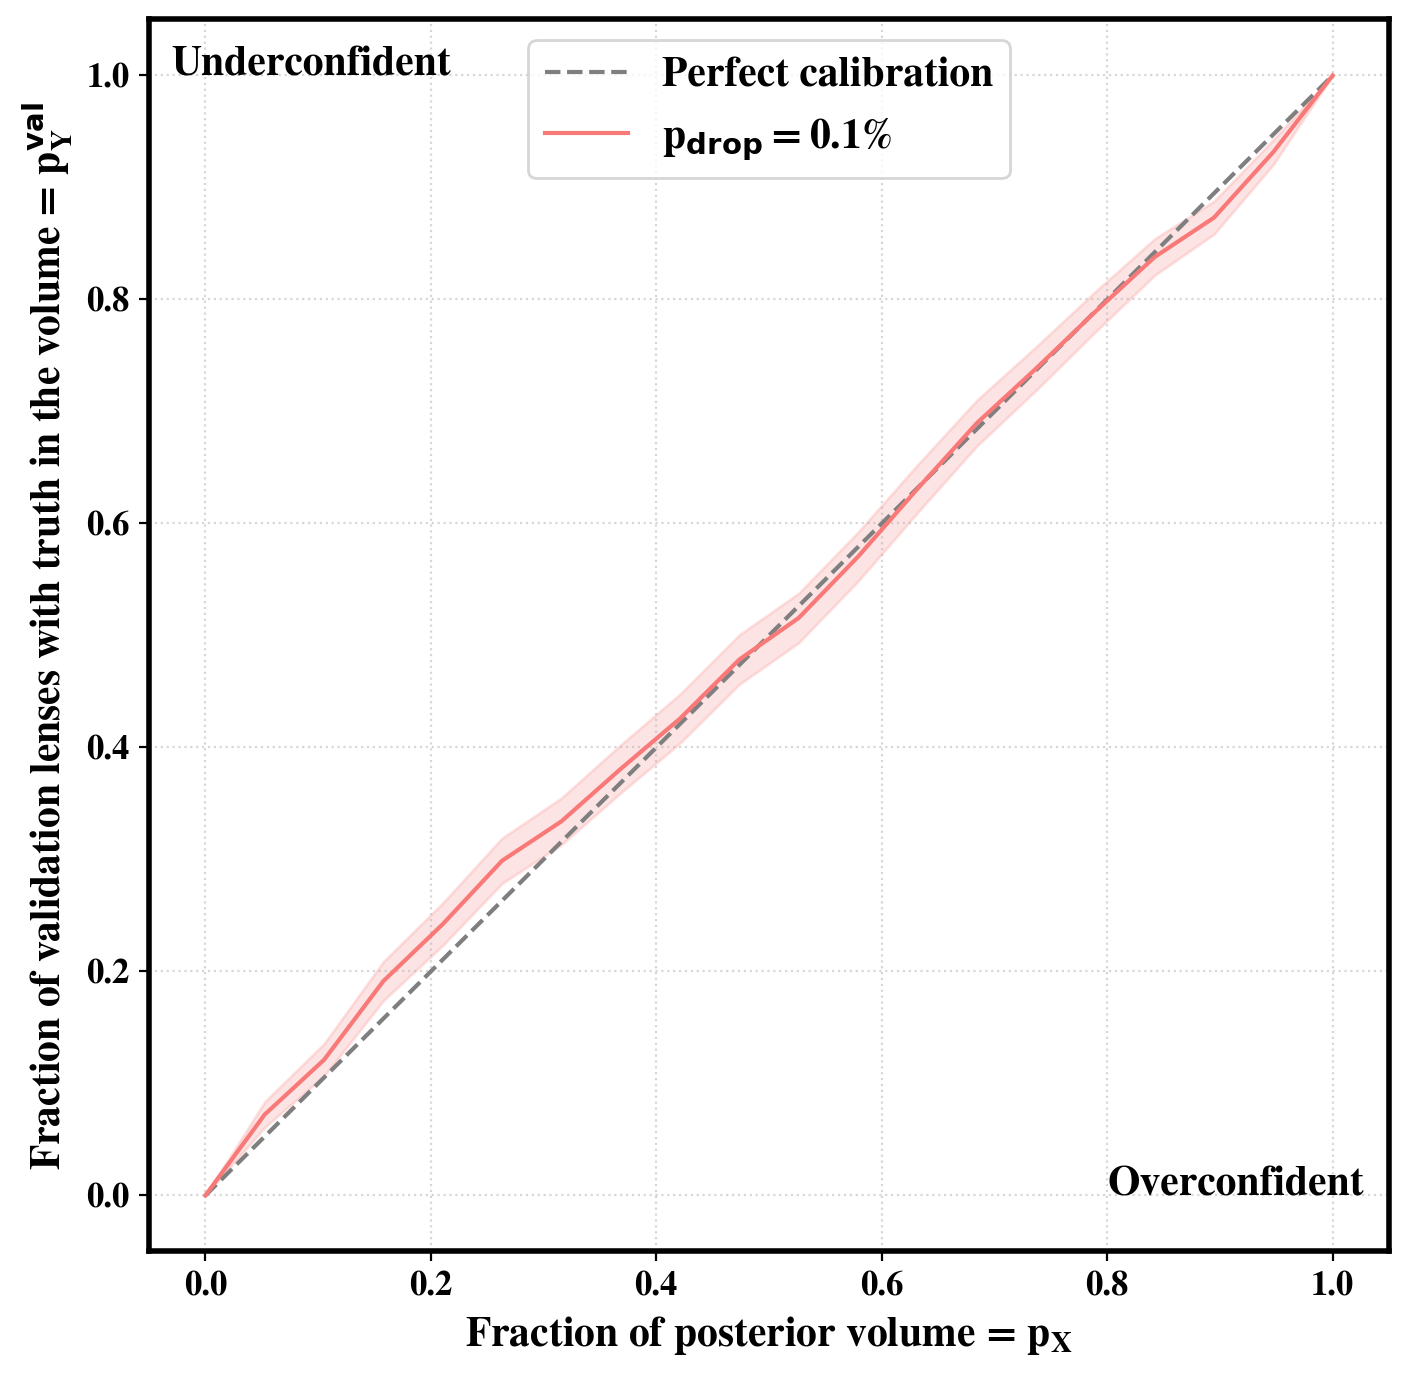

In [11]:
plt.close('all')
# Colors for each exposure time (in HST orbits)
colors_dict = dict(zip([2, 1, 0.5], ['#880519', '#c04546', '#f97978']))
dropout_to_linestyle = dict(zip([0, 0.001, 0.005], ['dotted', 'solid', 'dashdot']))
dropout_to_label = dict(zip([0, 0.001, 0.005], [r'$p_{\rm drop} = 0\%$', r'$p_{\rm drop} = 0.1\%$', r'$p_{\rm drop} = 0.5\%$']))

show_orbit = 0.5
 
first_dropout = dropouts_available[1]
fig = plot_calibration(predict_samps=np.transpose(samples[show_orbit][first_dropout], [2, 0, 1]), 
                       y_mean=mean[show_orbit][first_dropout][mcmc_Y_cols].values,
                       y_test=truth[show_orbit][first_dropout][mcmc_Y_cols].values,
                       cov_emp=train_cov, 
                       show_plot=False,
                       ls = dropout_to_linestyle[dropout_label_to_dropout_float[first_dropout]],
                       color_map=['tab:gray'] + [colors_dict[show_orbit]],
                       legend=['Perfect calibration', dropout_to_label[dropout_label_to_dropout_float[first_dropout]]])
if False:
    for d in dropouts_available[1:]:
        fig = plot_calibration(predict_samps=np.transpose(samples[show_orbit][d], [2, 0, 1]), 
                           y_mean=mean[show_orbit][d][mcmc_Y_cols].values,
                           y_test=truth[show_orbit][d][mcmc_Y_cols].values,
                           cov_emp=train_cov, 
                               figure=fig,
                           show_plot=False,
                           color_map=['tab:gray'] + [colors_dict[show_orbit]],
                               ls = dropout_to_linestyle[dropout_label_to_dropout_float[d]],
                           legend=['Perfect calibration', dropout_to_label[dropout_label_to_dropout_float[d]]])

if False:
    for o in orbits_available[1:]:
        fig = plot_calibration(predict_samps=np.transpose(samples[o], [2, 0, 1]), 
                               y_mean=mean[o][mcmc_Y_cols].values,
                               y_test=truth[o][mcmc_Y_cols].values,
                               cov_emp=train_cov,
                               figure=fig,
                               legend=['Perfect calibration', '{:d} orbit(s)'.format(o)],
                               show_plot=False,
                               color_map=['tab:gray'] + [colors_dict[o]])
plt.show()

In [71]:
fig.savefig('../calibration.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)

In [20]:
for param in ['lens_mass_center_x', 'src_light_center_x', 'lens_mass_center_y', 'src_light_center_y', 'lens_mass_gamma', 'lens_mass_theta_E', 'lens_mass_e1', 'lens_mass_e2', 'external_shear_gamma1', 'external_shear_gamma2', 'src_light_R_sersic']:
    for o in orbits_available:
        print(o)
        print(param)
        print("MAD: ", get_mad(mean[o][param].values, truth[o][param].values))
        print("bias: ", get_weighted_bias(mean[o][param].values, std[o][param].values, truth[o][param].values))
        print("precision: ", np.median(std[o][param].values))
        #print("h0rton: ", get_mad(h0rton_mean[param].values, h0rton_truth[param].values))
    print("===================================")

0.5
lens_mass_center_x
MAD:  0.0016154518174249927
bias:  (0.0006083443958712765, 0.0024809171483487938)
precision:  0.0042845864964135595
1
lens_mass_center_x
MAD:  0.0020367940423179944
bias:  (0.0011224102052712931, 0.002756075146500802)
precision:  0.004640630008975109
2
lens_mass_center_x
MAD:  0.0019804076598555487
bias:  (0.0012006301843701917, 0.0026786564165326853)
precision:  0.004690999132185025
0.5
src_light_center_x
MAD:  0.006199593249083632
bias:  (-0.00026407756876263675, 0.008556061458827676)
precision:  0.011980711835206385
1
src_light_center_x
MAD:  0.006651938578084965
bias:  (-8.139635182120408e-05, 0.00896352239697992)
precision:  0.012409970234803438
2
src_light_center_x
MAD:  0.006174182153899619
bias:  (5.052386916082911e-05, 0.008903975588111344)
precision:  0.012179964016096227
0.5
lens_mass_center_y
MAD:  0.0014675626815170706
bias:  (0.0005993789076288165, 0.0023074718122515657)
precision:  0.004338974165541256
1
lens_mass_center_y
MAD:  0.00173931515871621

In [22]:
for param in ['lens_mass_center_x', 'src_light_center_x', 'lens_mass_center_y', 'src_light_center_y', 'lens_mass_gamma', 'lens_mass_theta_E', 'lens_mass_e1', 'lens_mass_e2', 'external_shear_gamma1', 'external_shear_gamma2', 'src_light_R_sersic']:
    for o in orbits_available:
        print(o)
        print(param)
        print("MAD: ", get_mad(mean[o][param].values, truth[o][param].values))
        print("bias: ", get_weighted_bias(mean[o][param].values, std[o][param].values, truth[o][param].values))
        #print("h0rton: ", get_mad(h0rton_mean[param].values, h0rton_truth[param].values))
    print("===================================")

0.5
lens_mass_center_x
MAD:  0.001472354217484156
bias:  (0.0005712644779815685, 0.002290690575459746)
1
lens_mass_center_x
MAD:  0.0027680913052381267
bias:  (0.0013597860205633472, 0.002318641316765132)
2
lens_mass_center_x
MAD:  0.0026573077820023568
bias:  (0.0013065961956079753, 0.00223253019176826)
4
lens_mass_center_x
MAD:  0.0028379307266982005
bias:  (0.0008633986848160033, 0.0023894577678509545)
0.5
src_light_center_x
MAD:  0.0062716072695822725
bias:  (0.00015574631444261578, 0.009413481994648124)
1
src_light_center_x
MAD:  0.007406275375989618
bias:  (-0.00015767205256544115, 0.009094580255872085)
2
src_light_center_x
MAD:  0.00830864687363251
bias:  (-5.345390929753216e-05, 0.009055891652067705)
4
src_light_center_x
MAD:  0.008192354675338916
bias:  (0.0002034771195791996, 0.009346521285259105)
0.5
lens_mass_center_y
MAD:  0.001476724789560107
bias:  (-0.0003001296133847708, 0.0024992823497310846)
1
lens_mass_center_y
MAD:  0.0017021095213786142
bias:  (-0.0005199372294158

In [16]:
min_img_conf = min(mean[o].loc[truth[o]['n_img'] == 2].shape[0], mean[o].loc[truth[o]['n_img'] == 4].shape[0])
print(min_img_conf)

222


In [21]:
for param in ['lens_mass_center_x', 'src_light_center_x', 'lens_mass_center_y', 'src_light_center_y', 'lens_mass_gamma', 'lens_mass_theta_E', 'lens_mass_e1', 'lens_mass_e2', 'external_shear_gamma1', 'external_shear_gamma2', 'src_light_R_sersic']:
    for o in [2]:
        print(o)
        print(param)
        print("doubles")
        print("MAD: ", get_mad(mean[o].loc[truth[o]['n_img'] == 2][param].iloc[:min_img_conf].values, 
                               truth[o].loc[truth[o]['n_img'] == 2][param].iloc[:min_img_conf].values))
        print("bias: ", get_weighted_bias(mean[o].loc[truth[o]['n_img'] == 2][param].iloc[:min_img_conf].values,
                                          std[o].loc[truth[o]['n_img'] == 2][param].iloc[:min_img_conf].values, 
                                          truth[o].loc[truth[o]['n_img'] == 2][param].iloc[:min_img_conf].values))
        print("precision: ", np.median(std[o].loc[truth[o]['n_img'] == 2][param].iloc[:min_img_conf].values))
        #print("h0rton: ", get_mad(h0rton_mean[param].values, h0rton_truth[param].values))
        print("quads")
        print("MAD: ", get_mad(mean[o].loc[truth[o]['n_img'] == 4][param].iloc[:min_img_conf].values, 
                               truth[o].loc[truth[o]['n_img'] == 4][param].iloc[:min_img_conf].values))
        print("bias: ", get_weighted_bias(mean[o].loc[truth[o]['n_img'] == 4][param].iloc[:min_img_conf].values, 
                                          std[o].loc[truth[o]['n_img'] == 4][param].iloc[:min_img_conf].values, 
                                          truth[o].loc[truth[o]['n_img'] == 4][param].iloc[:min_img_conf].values))
        print("precision: ", np.median(std[o].loc[truth[o]['n_img'] == 4][param].iloc[:min_img_conf].values))
    print("===================================")

2
lens_mass_center_x
doubles
MAD:  0.0018169383593182051
bias:  (0.0014847884034798438, 0.0023723363354469654)
precision:  0.0046889752549773185
quads
MAD:  0.002059766016770076
bias:  (0.0011303510647125237, 0.002916459731888098)
precision:  0.004678145484040531
2
src_light_center_x
doubles
MAD:  0.007856562519623779
bias:  (-0.0009588529453846387, 0.01132488860482208)
precision:  0.01305690549018879
quads
MAD:  0.004685817542980197
bias:  (0.00036402294681443483, 0.00733989439994044)
precision:  0.010532641966032083
2
lens_mass_center_y
doubles
MAD:  0.0013680280639886966
bias:  (0.00019301166341025022, 0.002361014691782891)
precision:  0.004883524511021944
quads
MAD:  0.001708543740377226
bias:  (0.00011645198798162488, 0.0026389984928054766)
precision:  0.004983847455131765
2
src_light_center_y
doubles
MAD:  0.009704360383656005
bias:  (-0.0017901222785510866, 0.011222334467250732)
precision:  0.013386232367638036
quads
MAD:  0.00467151977009362
bias:  (-0.00103951554114272, 0.0070

In [ ]:
pixel_rms = np.zeros(200)
for i in range(200):
    img_i = np.load(os.path.join(cfg.out_dir, 'X_{0:07d}.npy'.format(i)))
    pixel_rms[i] = np.std(list(img_i[0, :2]) + list(img_i[0, -2:]) + list(img_i[:2, 0]) + list(img_i[-2:, 0]))

rms_bins = np.quantile(pixel_rms, [0.25, 0.5, 0.75, 1])


In [ ]:
for param in ['lens_mass_center_x', 'src_light_center_x', 'lens_mass_center_y', 'src_light_center_y', 'lens_mass_gamma', 'lens_mass_theta_E', 'lens_mass_e1', 'lens_mass_e2', 'external_shear_gamma1', 'external_shear_gamma2', 'src_light_R_sersic']:
    print(param)
    print("simple: ", get_mad(simple_mean[param].values, simple_truth[param].values))
    print("h0rton: ", get_mad(h0rton_mean[param].values, h0rton_truth[param].values))

In [ ]:
plt.close('all')
for o in [1, 4]:
    plt.hist((mean[o]['lens_mass_gamma'].values - truth[o]['lens_mass_gamma'].values)/std[o]['lens_mass_gamma'], density=True, bins=20, histtype='step', label=o)
plt.legend()
plt.show()

In [ ]:
plt.close('all')
for o in [1, 4]:
    plt.scatter(np.arange(200), np.abs(mean[o]['lens_mass_gamma'].values - truth[o]['lens_mass_gamma'].values), label=o)
plt.legend()
plt.show()